# Import Libraries

In [4]:
import math
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from math import sqrt
from pandas import concat
from matplotlib import pyplot
from keras.models import Sequential
from numpy import concatenate, asarray
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

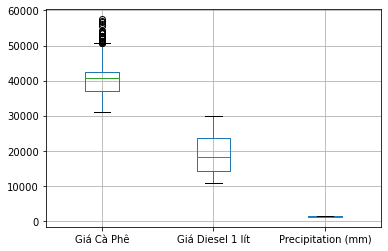

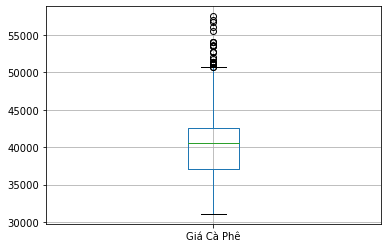

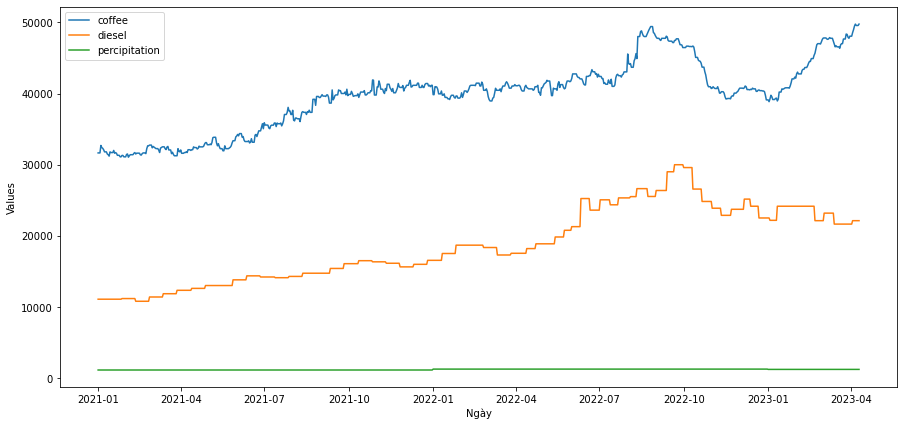

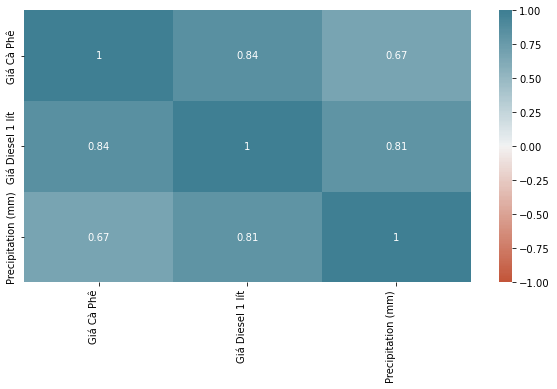

Stored 'data' (DataFrame)
592 148
(592, 1, 60) (592,) (148, 1, 60) (148,)
Stored 'train_X' (ndarray)
Stored 'train_y' (ndarray)
Stored 'test_X' (ndarray)
Stored 'test_y' (ndarray)


In [5]:
%run Data.ipynb

# ---------- Retrieve Data -----------

In [6]:
%store -r data
data

,Ngày,Giá Cà Phê,Giá Diesel 1 lít,Precipitation (mm)
0,2021-01-01,31667.5,11120.0,1174.199994
1,2021-01-02,31667.5,11120.0,1174.199994
2,2021-01-03,31667.5,11120.0,1174.199994
3,2021-01-04,32717.0,11120.0,1174.199994
4,2021-01-05,32417.0,11120.0,1174.199994
...,...,...,...,...
825,2023-04-06,49766.5,22150.0,1259.800013
826,2023-04-07,49566.5,22150.0,1259.800013
827,2023-04-08,49566.5,22150.0,1259.800013
828,2023-04-09,49566.5,22150.0,1259.800013


In [7]:
# take coffee price only
data.drop(data.columns[[-1, -2]], axis=1, inplace=True)

In [8]:
data

,Ngày,Giá Cà Phê
0,2021-01-01,31667.5
1,2021-01-02,31667.5
2,2021-01-03,31667.5
3,2021-01-04,32717.0
4,2021-01-05,32417.0
...,...,...
825,2023-04-06,49766.5
826,2023-04-07,49566.5
827,2023-04-08,49566.5
828,2023-04-09,49566.5


# --------- Normalization ----------

In [9]:
# drop date column
data.drop(data.columns[[0]], axis=1, inplace=True)

In [10]:
# set number of days
look_back = 60
predict_ahead = 30

# frame as supervised learning
reframed = series_to_supervised(data.values, look_back, predict_ahead)

In [11]:
# calculate total column to keep
data_column = len(data.columns)
keep_column = look_back * data_column
var_index = (look_back * data_column) + ((predict_ahead - 1) * data_column)

# drop unnecessary columns
reframed = reframed.drop(reframed.iloc[:, keep_column:var_index], axis = 1)
# index_drop = (data_column - 1 ) * -1
# reframed = reframed.drop(columns=reframed.columns[index_drop:], axis = 1)
# dataset = reframed

In [12]:
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(reframed)
scaled.shape

(740, 61)

In [29]:
scaled

array([[0.03272569, 0.03272569, 0.03272569, ..., 0.0826469 , 0.06180611,
        0.01101959],
       [0.03272569, 0.03272569, 0.08992071, ..., 0.06180611, 0.0720681 ,
        0.02559299],
       [0.03272569, 0.08992071, 0.07357149, ..., 0.0720681 , 0.06655831,
        0.        ],
       ...,
       [0.44957628, 0.45230115, 0.43050219, ..., 0.90633351, 0.9145982 ,
        0.98898041],
       [0.45230115, 0.43050219, 0.44412654, ..., 0.9145982 , 0.9090884 ,
        0.98898041],
       [0.43050219, 0.44412654, 0.49862394, ..., 0.9090884 , 0.9090884 ,
        1.        ]])

# ---------- Split data ----------

In [13]:
dataset = scaled

# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

592 148


In [14]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(592, 1, 60) (592,) (148, 1, 60) (148,)


# ---------- SARIMA ----------

In [56]:
from tqdm import tqdm  # Import tqdm for the progress bar

# Define a range of candidate values for 'm' (seasonal period)
candidate_m_values = list(range(7, 53))  # Include values from 7 to 52 (or adjust as needed)

# Initialize variables to track the best model and AIC score
best_model = None
best_aic = float("inf")

# Use tqdm for the progress bar
for m in tqdm(candidate_m_values, desc="Searching for the best m"):
    # Use auto_arima to find the best SARIMA model for the current 'm'
    model = auto_arima(
        train_y,
        exogenous=train_X,
        seasonal=True,
        m=m,
        stepwise=True,
        trace=False,
        suppress_warnings=True,
        error_action="ignore",
    )
    
    # Get the AIC score of the current model
    current_aic = model.aic()
    
    # Check if the current model has a lower AIC score than the best model
    if current_aic < best_aic:
        best_aic = current_aic
        best_model = model


Searching for the best m: 100%|██████████| 46/46 [25:26<00:00, 33.18s/it] 


In [59]:
# Print the best model summary
print(best_model.summary())

# Get the best SARIMA model's order parameters and 'm' value
p, d, q = best_model.order
P, D, Q, s = best_model.seasonal_order

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  592
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 11)   Log Likelihood                1401.382
Date:                              Wed, 06 Sep 2023   AIC                          -2792.764
Time:                                      03:07:07   BIC                          -2770.855
Sample:                                           0   HQIC                         -2784.229
                                              - 592                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0954      0.037     -2.558      0.011      -0.168      -0.022
ma.L2         -0.05

# Get the best SARIMA model's order parameters and 'm' value
p, d, q = best_model.order
P, D, Q, s = best_model.seasonal_order

from pmdarima import auto_arima

# 'm' seasonal period:
#best_m = 30 #weekly pattern

# Use auto_arima to find the best SARIMA model
best_model = auto_arima(train_y, exogenous=train_X,
                        start_p=0, start_q=0,
                           max_p=5, max_q=5, m=best_m,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(best_model.aic())

(Repetitive process) Plot predicted khac biet lon ve trend, final -> chay func tim ra best param -> run model -> plot predicted

In [60]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Get the best SARIMA model's order parameters
#best_sarima_order = (4, 1, 0)
#best_seasonal_order = (2, 1, 0, 7)

# Create and fit the SARIMA model
model = SARIMAX(train_y, exog=train_X, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

# Make predictions on the test set
predictions = results.predict(start=len(train_y), end=len(train_y) + len(test_y) - 1, exog=test_X)

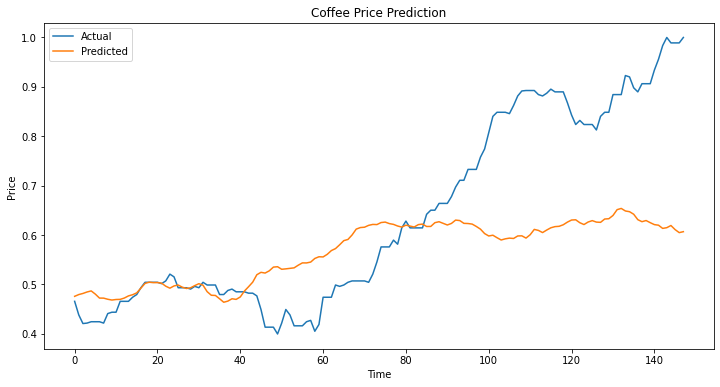

In [61]:
# -----Plot actual vs. predicted prices-------
plt.figure(figsize=(12, 6))
plt.plot(test_y, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("Coffee Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [ ]:
# Calculate RMSE (Root Mean Squared Error) to evaluate the model
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print(f"RMSE: {rmse}")

# ---------- Train Model ----------

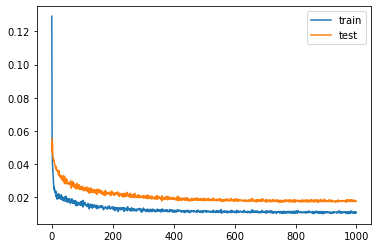

In [15]:
# design network
model = Sequential()
model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=32, 
                    validation_data=(test_X, test_y), verbose=False, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# ---------- Testing & Results Analysis ----------

In [16]:
# calculate metrics
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = sklearn.metrics.mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

def print_metrics(test, pre_test):
    
    testScore = np.sqrt(mean_squared_error(test,pre_test))
    print('RMSE: %.2f (đồng)' % (testScore))
    
    testScore = sklearn.metrics.mean_absolute_error(test, pre_test)
    print('\nMAE: %.2f (đồng)' % (testScore))
                            
    testScore = sklearn.metrics.mean_absolute_percentage_error(test, pre_test)
    print('\nMAPE: %.2f' % (testScore))
    
    testScore = mean_absolute_scaled_error(test, pre_test, test)
    print('\nMASE: %.2f' % (testScore))

In [17]:
# make a prediction
test_pred = (model.predict(test_X))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

5/5 [==============================] - 0s 1ms/step


In [18]:
# invert scaling for forecast
inv_test_pred = concatenate((test_pred, test_X), axis=1)
inv_test_pred = scaler.inverse_transform(inv_test_pred)
inv_test_pred = inv_test_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [19]:
# print results
print_metrics(inv_y, inv_test_pred)

RMSE: 2446.19 (đồng)

MAE: 1837.55 (đồng)

MAPE: 0.04

MASE: 10.55


# ---------- Predicting ----------

In [20]:
# take the last look back days
df = data.tail(look_back)

In [21]:
# normalize features
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [22]:
# convert rows to columns
dataset = df.T

# convert
# dataset = df.to_numpy() 

# reshape
X = dataset.reshape((dataset.shape[0], 1, dataset.shape[1]))

In [23]:
# predict
prediction = model.predict(X)

1/1 [==============================] - 0s 12ms/step


In [24]:
# replace 1st value by prediction result in order to invert scale
df[0] = prediction

# invert scaling
inv_prediction = scaler.inverse_transform(df)
final_result = inv_prediction[0]

In [25]:
final_result[0]

49266.59149312972